<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propagation analysis of Greek proverbs

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens
* Using linguistic distance as a means to seek for possible routes the Greek proverbs may have travelled spatially.
---


In [1]:
%%capture
!pip install python-Levenshtein
import pandas as pd
from Levenshtein import distance as lev
import numpy as np
import seaborn as sns
import networkx as nx
import ast

In [2]:
proverbs = pd.read_csv("data/proverbs.csv", index_col=0)
proverbs

,text,place,uri,collector
0,Απο Μαρθιού και Σεπτεβριού ίσα τα μερονύχτια,"Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/278955,"Αικατερινίδης, Γεώργιος Ν."
1,"Απου πνιγεί και σκοτωθή, κακού θανατου πάει","Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/260188,"Αικατερινίδης, Γεώργιος Ν."
2,Αυτός δεν ξέρει να ρετσινώνη το δοξάρι,"Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/290466,"Αικατερινίδης, Γεώργιος Ν."
3,Η καλή δουλειά άργιο έχει κ' η κακή περγέλιο έχει,"Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/213730,"Αικατερινίδης, Γεώργιος Ν."
4,Κάθε μία κατσούνα σύρνει ομπρός τζη,"Κρήτη, Λασίθι, Τουρτούλοι",http://hdl.handle.net/20.500.11853/183525,"Αικατερινίδης, Γεώργιος Ν."
...,...,...,...,...
134488,Απ' ούλα τα φαΓια το ρύζ' και τσόχα να φορής,"Θράκη, Σαμακόβι",http://hdl.handle.net/20.500.11853/245653,anonymous
134489,Απ' τ' Άη – Λιός και μπρός γυρίζει ο καιρός αλ...,"Μεσσηνία, Φιλιατρά",http://hdl.handle.net/20.500.11853/160335,anonymous
134490,Απ' τ' Άι – Ηλιά το βράδυ βάζει η ελιά το λάδι,Σίφνος,http://hdl.handle.net/20.500.11853/190853,anonymous
134491,Απ' τ' άλουγου στου γουμάρι,Ήπειρος,http://hdl.handle.net/20.500.11853/159862,anonymous


In [3]:
# the duplicates, geolocated in this study
duplicates = pd.read_csv('data/duplicates_geolocated.csv')
duplicates['place'] = duplicates['place'].apply(ast.literal_eval)
duplicates['area'] = duplicates['area'].apply(ast.literal_eval)
duplicates

,text,place,place_num,area,area_num,latlon
0,(Ε)πήρε βάγια,"{Ήπειρος, Λακωνία}",2,"{Ήπειρος, Λακωνία}",2,"[(37.9574332, 23.7108518), (36.76027945, 22.79..."
1,"Άβολος ο νους, διπλός ο κόπος","{Νίσυρος, Μικρά Ασία>Τσεσμές (Κρήνη)}",2,"{Μικρά Ασία, Νίσυρος}",2,"[(36.58904575, 27.16918402255752), (38.1846366..."
2,Άβουλος νους διπλός κόπος,"{Θράκη>Αίνος, Θήρα (Σαντορίνη)}",2,"{Θράκη, Θήρα (Σαντορίνη)}",2,"[(40.8464241, 25.8759377), (36.4044251, 25.395..."
3,"Άβουλος νους, διπλός ο κόπος","{Ρόδος, Αμοργός, Κρήτη}",3,"{Ρόδος, Αμοργός, Κρήτη}",3,"[(36.85252415, 25.89848696771565), (35.3084952..."
4,Άβουλος ο νους διπλός ο κόπος,"{Ήπειρος>Τσαμαντάς, Θράκη>Μάδυτος, Θράκη, Σάμο...",5,"{Ήπειρος, Θράκη, Σάμος, Ρόδος}",4,"[(40.8464241, 25.8759377), (37.9574332, 23.710..."
...,...,...,...,...,...,...
3199,"ο παθός, μαθός","{Λέρος, Αργολίδα>Σχοινοχώρι}",2,"{Αργολίδα, Λέρος}",2,"[(37.56626615, 22.85593894780862), (37.1494507..."
3200,πονάει το δόντι,"{Φωκίδα, Θεσσαλία>Τρίκαλα}",2,"{Φωκίδα, Θεσσαλία}",2,"[(38.4998681, 22.24878032919352), (39.5594194,..."
3201,"που Πάτρα, που Φλομίτσι!","{Μάνη>Αβία, Μεσσηνία>Αβία>Κάμπος}",2,"{Μεσσηνία, Μάνη}",2,"[(36.986899050000005, 21.82712495001949), (41...."
3202,τού έδειξε τα δόντια,"{Εύβοια, Αρκαδία>Τεγέα}",2,"{Αρκαδία, Εύβοια}",2,"[(38.0368583, 23.6689264), (38.49417235, 23.91..."


In [4]:
geolocs = pd.read_csv("data/geolocs.csv")
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Ανατολική Θράκη,Αδριανούπολη,Φθιώτιδα,Ανδρίτσαινα Ολυμπίου,Δαρδανέλλια (Ελλήσποντος),Στερεά Ελλάδα,Αερόπολη,Τριφυλία,Φωκίδα,Δυτική Μάνη
0,35.308495,36.971401,41.091071,39.365088,37.957433,38.706573,38.069275,38.494172,40.686029,34.982302,...,41.675933,41.675933,38.88734,37.483836,40.337606,38.562460,36.665918,37.195013,38.499868,22.581762
1,24.463342,24.708110,23.549803,23.135561,23.710852,20.641709,21.872730,23.911084,23.693390,33.145128,...,26.558722,26.558722,22.36803,21.905533,26.640821,23.161853,22.381635,21.703732,22.248780,88.399181


In [5]:
# basic processing
proverbs = proverbs[proverbs.collector!="anonymous"]
geolocs.index=["lat", "lon"]
geolocs = geolocs.to_dict()
geolocs

{'Κρήτη': {'lat': 35.3084952, 'lon': 24.46334231842296},
 'Σίφνος': {'lat': 36.9714014, 'lon': 24.70811041776585},
 'Σέρρες': {'lat': 41.0910711, 'lon': 23.5498031},
 'Πήλιο': {'lat': 39.3650875, 'lon': 23.1355607},
 'Ήπειρος': {'lat': 37.9574332, 'lon': 23.7108518},
 'Λευκάδα': {'lat': 38.7065734, 'lon': 20.641708855541477},
 'Αχαΐα': {'lat': 38.0692748, 'lon': 21.87273042232539},
 'Εύβοια': {'lat': 38.49417235, 'lon': 23.91108439913793},
 'Μακεδονία': {'lat': 40.6860291, 'lon': 23.6933899},
 'Κύπρος': {'lat': 34.9823018, 'lon': 33.1451285},
 'Πέλλα': {'lat': 40.7541229, 'lon': 22.517832973183303},
 'Λέσβος': {'lat': 39.17584185, 'lon': 25.99891345023241},
 'Θράκη': {'lat': 40.8464241, 'lon': 25.8759377},
 'Ρούμελη': {'lat': 35.4049682, 'lon': 24.7001033},
 'Κοζάνη': {'lat': 40.3007259, 'lon': 21.7883119},
 'Σάμος': {'lat': 37.72461615, 'lon': 26.81929189110984},
 'Αρκαδία': {'lat': 38.0368583, 'lon': 23.6689264},
 'Ίμβρος': {'lat': 35.2541539, 'lon': 24.1704124},
 'Σκύρος': {'lat': 3

In [6]:
# adding lat/lon/area information
proverbs['area'] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs = proverbs[proverbs.lon.notna()&proverbs.lat.notna()]
proverbs

,text,place,uri,collector,area,lat,lon
0,Απο Μαρθιού και Σεπτεβριού ίσα τα μερονύχτια,"Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/278955,"Αικατερινίδης, Γεώργιος Ν.",Κρήτη,35.308495,24.463342
1,"Απου πνιγεί και σκοτωθή, κακού θανατου πάει","Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/260188,"Αικατερινίδης, Γεώργιος Ν.",Κρήτη,35.308495,24.463342
2,Αυτός δεν ξέρει να ρετσινώνη το δοξάρι,"Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/290466,"Αικατερινίδης, Γεώργιος Ν.",Κρήτη,35.308495,24.463342
3,Η καλή δουλειά άργιο έχει κ' η κακή περγέλιο έχει,"Κρήτη, Λασίθι, Κεντρί",http://hdl.handle.net/20.500.11853/213730,"Αικατερινίδης, Γεώργιος Ν.",Κρήτη,35.308495,24.463342
4,Κάθε μία κατσούνα σύρνει ομπρός τζη,"Κρήτη, Λασίθι, Τουρτούλοι",http://hdl.handle.net/20.500.11853/183525,"Αικατερινίδης, Γεώργιος Ν.",Κρήτη,35.308495,24.463342
...,...,...,...,...,...,...,...
119488,Φκιάντσ' κατ' δ'λειές ούτι τα σ'κκλιά δε τ'ς τρων,"Ημαθία, Βέροια",http://hdl.handle.net/20.500.11853/255865,"Ψωμά, Ελένη",Ημαθία,40.517038,22.180720
119489,Χαμπ'λα – χαμπ'λά τα μάτια κι σφούγγα τα κουμμ...,"Ημαθία, Βέροια",http://hdl.handle.net/20.500.11853/279241,"Ψωμά, Ελένη",Ημαθία,40.517038,22.180720
119490,Χουρίς υτία κι' αφουρμή χάρους ψυχή δεν παίρνει,"Ημαθία, Βέροια",http://hdl.handle.net/20.500.11853/159500,"Ψωμά, Ελένη",Ημαθία,40.517038,22.180720
119491,Ψώραβ' γίδα τ' νουρά σκαπάν',"Ημαθία, Βέροια",http://hdl.handle.net/20.500.11853/201724,"Ψωμά, Ελένη",Ημαθία,40.517038,22.180720


## Proverb spatial propagation

* Besides (text-) duplicates, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* Using linguistic distance, we can estimate the route of a proverb, assuming that shorter travels lead to fewer edits.

In [7]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)
highly_distr

,text,place,place_num,area,area_num,latlon
1313,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κοζάνη>Βόϊο>Ανθούσα, Ικαρία>Μάραθος, Μικρά Ασ...",45,"{Ιωάννινα, Ρούμελη, Καστοριά, Ημαθία, Μικρά Ασ...",23,"[(40.51703795, 22.18071972652394), (39.6327644..."
2688,Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Κοζάνη>Κοντοβούνι, Φωκίδα>Δελφοί, Λακωνία, Άν...",26,"{Φωκίδα, Λακωνία, Άνδρος, Ιωάννινα, Ρούμελη, Κ...",20,"[(39.6327644, 22.3965233), (38.4998681, 22.248..."
762,"Ανεμομαζώματα, διαβολοσκορπίσματα","{Καστοριά, Αδριανούπολη, Θράκη>Αυδήμιο, Μικρά ...",28,"{Δαρδανέλλια (Ελλήσποντος), Τήλος, Αρκαδία, Κρ...",18,"[(36.85252415, 25.89848696771565), (40.3376058..."


* First we'll need a function that finds near duplicates of a text among a set of candidate texts and their respective regions.

* By default we consider near duplicates those with an edit distance less than or equal to five.

In [8]:
def find_near_duplicates(text, candidate_texts, candidate_areas, max_edits=5):
    distances = [lev(x, target) for x in candidate_texts]
    candidates = pd.DataFrame({'text':candidate_texts, 'lev': distances, 'area': candidate_areas})
    near_duplicates = candidates[(candidates.lev < max_edits) & (candidates.lev > 0)]
    near_duplicates = near_duplicates.sort_values("lev", ascending=False)
    return near_duplicates

* We'll also need a helper function that checks whether a list has no two consecutive duplicates.

* This will be used to ensure that we do not move from a area to the same area.

In [9]:
def has_no_consecutive_duplicates(lst):
    for a, b in zip(lst, lst[1:]):
        if a == b:
            return False
    return True

In [10]:
# Calculate direct distances matrix.

def find_indirect_paths(near_duplicates, verbose=0):
    n = len(near_duplicates)
    direct_dist_matrix = np.zeros((n, n))

    for u in range(n):
        for v in range(n):
            direct_dist_matrix[u, v] = lev(near_duplicates['text'].iloc[u], near_duplicates['text'].iloc[v])

    # Now calculate shortest paths, not necessarily direct.

    dist_matrix = np.zeros((n, n))
    G = nx.from_numpy_array(direct_dist_matrix, parallel_edges=False, create_using=nx.Graph)

    shortest_path_lengths = dict(nx.all_pairs_dijkstra_path_length(G))
    indirect_shortest_paths = {}
    num_indirect_shortest_paths = 0
    for u in range(n):
        for v in range(n):
            u_v_shortest_paths = nx.all_shortest_paths(G, u, v, weight='weight')
            for path in u_v_shortest_paths:
                if len(path) > 2:
                    if u not in indirect_shortest_paths:
                        indirect_shortest_paths[u] = { }
                    if v not in indirect_shortest_paths[u]:
                        indirect_shortest_paths[u][v] = []
                    indirect_shortest_paths[u][v].append(path)
                    num_indirect_shortest_paths += 1
            if direct_dist_matrix[u][v] != 0:
                dist_matrix[u][v] = shortest_path_lengths[u][v]

    for u, v_paths in indirect_shortest_paths.items():
        out = []
        clean_pahts = []
        for v, paths in v_paths.items():
            decoded_paths = [ 
                [near_duplicates['area'].iloc[node] for node in path] 
                for path in paths
            ]
            proverb_paths = [
                [near_duplicates['text'].iloc[node] for node in path] 
                for path in paths
            ]
            if verbose > 0:
                print(f'shortest indirect paths {u}->{v}:')
                print(f'{paths}: {decoded_paths}')
            non_trivial_paths = []
            non_trivial_decoded_paths = []
            non_trival_proverb_paths = []
            for (p, dp, pp) in zip(paths, decoded_paths, proverb_paths):
                if has_no_consecutive_duplicates(dp) and dp[0] != dp[-1]:
                    non_trivial_paths.append(p)
                    non_trivial_decoded_paths.append(dp)
                    non_trival_proverb_paths.append(pp)
            if verbose > 0:
                print('shortest non trivial paths')
            if len(non_trivial_decoded_paths) > 0:
                out.extend([(dp, non_trival_proverb_paths[i])
                            for i, dp in enumerate(non_trivial_decoded_paths)])
                if verbose > 0:
                    print(non_trivial_paths)
                    print(non_trivial_decoded_paths)
                    print(non_trival_proverb_paths)
                    print('---')
            else:
                if verbose > 0:
                    print('None')
        return out

In [11]:
#@title Use case: ''The tongue doesn't have bones, yet bones it crashes''

i = 0

target = highly_distr.reset_index().iloc[i].text
print(target)
source_areas = highly_distr.iloc[i].area
print('source areas:', source_areas)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values)
new_areas = set(ndups.area.values) - source_areas
print('target areas:', new_areas)
print('number of target areas:', len(new_areas))

find_indirect_paths(ndups)

Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει
source areas: {'Ιωάννινα', 'Ρούμελη', 'Καστοριά', 'Ημαθία', 'Μικρά Ασία', 'Ανατολική Θράκη', 'Κρήτη', 'Κύπρος', 'Ήπειρος', 'Κοζάνη', 'Αρκαδία', 'Μάνη', 'Ικαρία', 'Θεσπρωτία', 'Δαρδανέλλια (Ελλήσποντος)', 'Πήλιο', 'Αργολίδα', 'Νάξος', 'Νίσυρος', 'Εύβοια', 'Φιλιππούπολη', 'Θράκη', 'Αχαΐα'}
target areas: {'Σκύρος', 'Νάουσα', 'Αδριανούπολη', 'Μακεδονία', 'Ρόδος', 'Κως'}
number of target areas: 6


[(['Κύπρος', 'Μακεδονία', 'Θράκη'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει",
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'"]),
 (['Κύπρος', 'Ρούμελη', 'Νάουσα'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   'Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει"]),
 (['Κύπρος', 'Μακεδονία', 'Νάουσα'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει",
   "Η γλώσσα κόκκαλα δεν έχ' κι κόκκαλα τσ'κίζει"]),
 (['Κύπρος', 'Μακεδονία', 'Θράκη'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει",
   "Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'"]),
 (['Κύπρος', 'Ρούμελη', 'Κοζάνη'],
  ['Η γλώσσα κόκκαλα εν έσει τζαι κόκκαλα τσακίζει',
   'Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζει',
   "Η γλώσσα κόκκαλα δεν έχει κι κόκκαλα τσακίζ'ει"])]

### Alternative: Agglomerative clustering

```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Fetching versions up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [12]:
target = highly_distr.reset_index().iloc[0].text
print(target)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values)

Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει


In [13]:
loc_name = {'Ρούμελη':'Roumeli', 'Κοζάνη':'Kozani', 'Κως':'Kos', 'Αδριανούπολη':'Adrian.', 'Νάουσα':'Naousa', 'Σέρρες':'Serres', 'Σίφνος': 'Sifnos', 'Ήπειρος':'Epirus', 'Αιτωλία':'Etolia', 'Αμοργός':'Amorgos', 'Ανατολική Θράκη': 'East Thrace',
            'Αρκαδία':'Arcadia', 'Αχαΐα':'Achaia', 'Επτάνησος':'Eptanisos', 'Εύβοια':'Eyvoia', 'Θεσπρωτία':'Thesprotia', 
             'Θράκη': 'Thrace', 'Ιωάννινα':'Ioannina', 'Κάρπαθος':'Karpathos', 'Κεφαλληνία':'Kefalinia', 'Κρήτη':'Crete',
            'Κύπρος':'Cyprus', 'Λέσβος':'Lesvos', 'Λακωνία':'Laconia', 'Μακεδονία':'Maced.', 'Μικρά Ασία':'Asia Minor',
            'Νάξος':'Naxos', 'Πόντος':'Pontos', 'Ρόδος':'Rodos', 'Σκύρος':'Skyros'}
areas = ndups.area.apply(lambda a: loc_name[a]).values

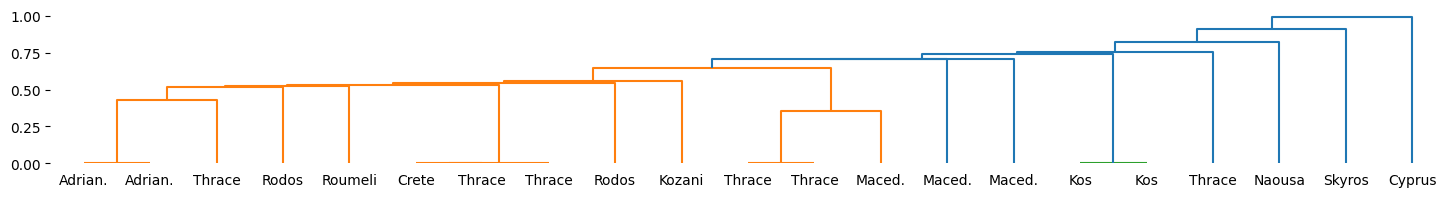

In [14]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
vec = TfidfVectorizer(analyzer="char", ngram_range=(2,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(ndups.text.values)
Z = linkage(X.toarray(), 'single')
fig = plt.figure(figsize=(18, 2))
ax = dendrogram(Z, orientation='top', labels=areas, distance_sort='descending', show_leaf_counts=False, leaf_font_size=10., show_contracted=True, leaf_rotation=0);
sns.despine(left=True, bottom=True);
fig.savefig('tongue.pdf', format="PDF", dpi=300)

In [15]:
clustering = fcluster(Z, t=0.4, criterion='distance')
ndups.insert(3, "clustering", clustering)
grouped = ndups.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

,cluster,text
clustering,,
1,"[Κως, Κως]",[Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακί...
2,"[Θράκη, Θράκη, Μακεδονία]","[Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ',..."
3,"[Θράκη, Κρήτη, Θράκη]","[Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί,..."
4,"[Αδριανούπολη, Αδριανούπολη]","[Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,..."


In [16]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()

Θράκη --> Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζ'
Μακεδονία --> Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει

Θράκη --> Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί
Κρήτη --> Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί



## Two more use cases

In [ ]:
#@title ''Knocking on a deaf man's door''

i = 1

target = highly_distr.reset_index().iloc[i].text
print(target)
source_areas = highly_distr.iloc[i].area
print('source areas:', source_areas)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values)
new_areas = set(ndups.area.values) - source_areas
print('target areas:', new_areas)
print('number of target areas:', len(new_areas))

find_indirect_paths(ndups)

Στου κουφού την πόρτα όσο θέλεις βρόντα
source areas: {'Φωκίδα', 'Λακωνία', 'Άνδρος', 'Ιωάννινα', 'Ρούμελη', 'Καστοριά', 'Ανατολική Θράκη', 'Κρήτη', 'Σέρρες', 'Κοζάνη', 'Αρκαδία', 'Ικαρία', 'Θεσπρωτία', 'Νάξος', 'Νίσυρος', 'Φιλιππούπολη', 'Πέλλα', 'Θράκη', 'Πρέβεζα', 'Κεφαλληνία'}
target areas: {'Λέσβος', 'Κάρπαθος', 'Μικρά Ασία', 'Αδριανούπολη', 'Μήλος', 'Ηλεία', 'Κύπρος', 'Ήπειρος', 'Κορινθία', 'Κως', 'Σάμος', 'Ρόδος', 'Δαρδανέλλια (Ελλήσποντος)', 'Αργολίδα', 'Κέρκυρα', 'Εύβοια', 'Χίος', 'Μακεδονία', 'Αχαΐα'}
number of target areas: 19


In [18]:
#@title ''Easy come easy go''

i = 2

target = highly_distr.reset_index().iloc[i].text
print(target)
source_areas = highly_distr.iloc[i].area
print('source areas:', source_areas)
ndups = find_near_duplicates(target, proverbs.text.values, proverbs.area.values, 3)
new_areas = set(ndups.area.values) - source_areas
print('target areas:', new_areas)
print('number of target areas:', len(new_areas))

find_indirect_paths(ndups)

Ανεμομαζώματα, διαβολοσκορπίσματα
source areas: {'Δαρδανέλλια (Ελλήσποντος)', 'Τήλος', 'Αρκαδία', 'Κρήτη', 'Ήπειρος', 'Καστοριά', 'Νάξος', 'Αμοργός', 'Μικρά Ασία', 'Χίος', 'Εύβοια', 'Αργολίδα', 'Αδριανούπολη', 'Μακεδονία', 'Θράκη', 'Κοζάνη', 'Αχαΐα', 'Κως'}
target areas: {'Θεσσαλία', 'Λακωνία', 'Κύπρος', 'Ρούμελη', 'Ημαθία', 'Ανατολική Θράκη', 'Θεσπρωτία', 'Φιλιππούπολη', 'Επτάνησος', 'Βοιωτία', 'Κεφαλληνία', 'Αιτωλοακαρνανία'}
number of target areas: 12


[(['Βοιωτία', 'Ημαθία', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Θράκη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Κρήτη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Μικρά Ασία', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Ανατολική Θράκη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Ρούμελη', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαβολοσκορπίσματα',
   'Ανεμομαζώματα διαολοσκορπίσματα']),
 (['Βοιωτία', 'Μικρά Ασία', 'Νάξος'],
  ['Ανεμομαζώματα – διαβολ